In [153]:
!pip install statsmodels
!pip install xgboost
!pip install torch

In [154]:
#Required Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import TimeSeriesSplit
import time
from prophet import Prophet 
import warnings
warnings.filterwarnings("ignore")
import pickle

# User-defined Functions


In [155]:
def autocorrelation_lags(num,step,df):
    for i in range(1,num,step):
        lag =  df['Receipt_Count'].autocorr(lag=i)
        print('autocorrelation_lags',i ,':' ,lag )
        
def mean_squared_error(y_true, y_pred):
    squared_error = (y_true - y_pred)**2
    return np.mean(squared_error)

def createFeatures(df):
    df = df.copy()
    df['dayofweek']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofmonth']=df.index.day
    df['dayofyear']=df.index.dayofyear
    df['weekoftheyear']=df.index.isocalendar().week
    return df
global createFeatures

def add_lags(df):
    target_map =df['Receipt_Count'].to_dict()
    df['lag1']=(df.index-pd.Timedelta('91 days')).map(target_map)
    df['lag2']=(df.index-pd.Timedelta('182 days')).map(target_map)
    df['lag3']=(df.index-pd.Timedelta('273 days')).map(target_map)
    df['lag4']=(df.index-pd.Timedelta('364 days')).map(target_map)
    return df
global add_lags



# Loading Data

In [156]:
df = pd.read_csv('../data/data_daily.csv',index_col='# Date')

In [157]:
df.head()

,Receipt_Count
# Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


In [158]:
df=df.rename(columns={'# Date': 'Date'})
dataframe = df

In [159]:
df.index=pd.to_datetime(df.index)

# Data Analysis

In [160]:
df.describe()

,Receipt_Count
count,3.650000e+02
mean,8.826566e+06
std,7.820089e+05
min,7.095414e+06
25%,8.142874e+06
50%,8.799249e+06
75%,9.476970e+06
max,1.073886e+07


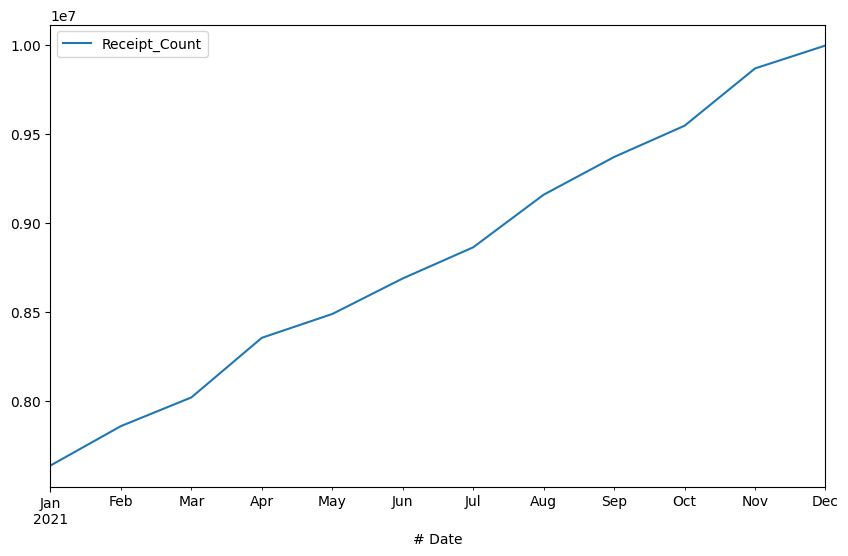

In [161]:
df.resample(rule='M').mean().plot();

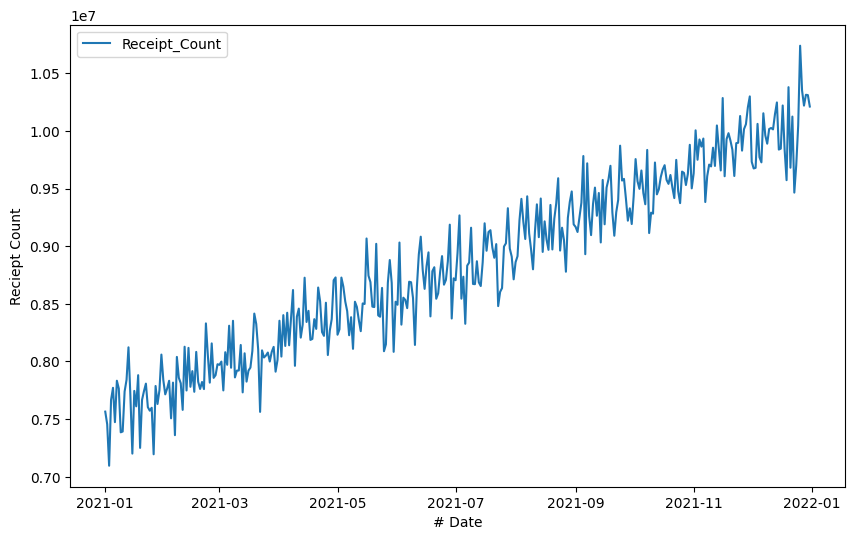

In [162]:
sns.lineplot(df)
plt.ylabel('Reciept Count')
plt.show()

In [163]:
df.tail()

,Receipt_Count
# Date,
2021-12-27,10350408
2021-12-28,10219445
2021-12-29,10313337
2021-12-30,10310644
2021-12-31,10211187


# Stationarity of Data

In [164]:
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()

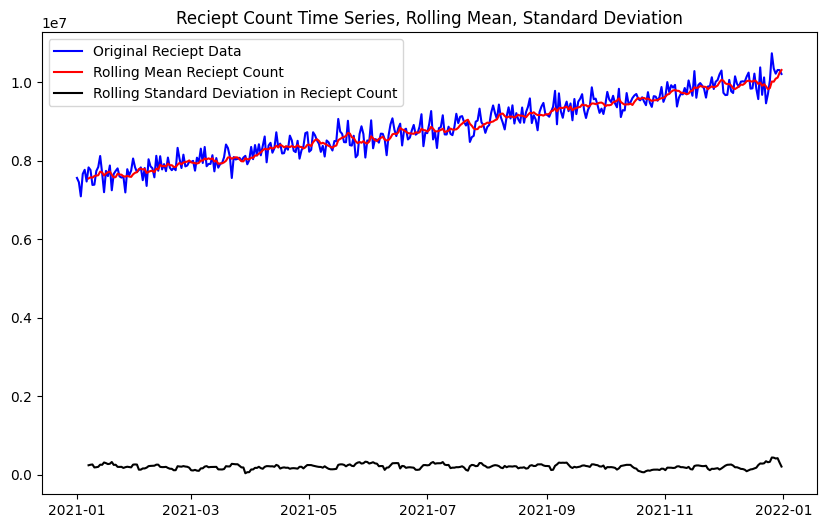

In [165]:
plt.plot(df, color="blue",label="Original Reciept Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Reciept Count")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Reciept Count")
plt.title("Reciept Count Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

In [166]:
adft = adfuller(df,autolag="AIC")

In [167]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    0.175044              Test Statistics
1    0.970827                      p-value
2   17.000000             No. of lags used
3  347.000000  Number of observations used
4   -3.449337          critical value (1%)
5   -2.869906          critical value (5%)
6   -2.571227         critical value (10%)


In [168]:
# The given data is not stationary as the Augmented Dickey Fuller (“ADF”) test's P-value is greater than 0.5
#Now checking for Autocorrelation
autocorrelation_lag1 = df['Receipt_Count'].autocorr(lag=1)
print("1 Days Lag: ", autocorrelation_lag1)

1 Days Lag:  0.9247303360311816


In [169]:
# we can see that the data is highly correlated
num_lag = 180
step = 20
autocorrelation_lags(num_lag,step,df)

autocorrelation_lags 1 : 0.9247303360311816
autocorrelation_lags 21 : 0.9112605951402099
autocorrelation_lags 41 : 0.9110364794285617
autocorrelation_lags 61 : 0.8890441999129224
autocorrelation_lags 81 : 0.8623421804206457
autocorrelation_lags 101 : 0.8486912819535416
autocorrelation_lags 121 : 0.8239378317112811
autocorrelation_lags 141 : 0.8198227803688078
autocorrelation_lags 161 : 0.7832810815616251


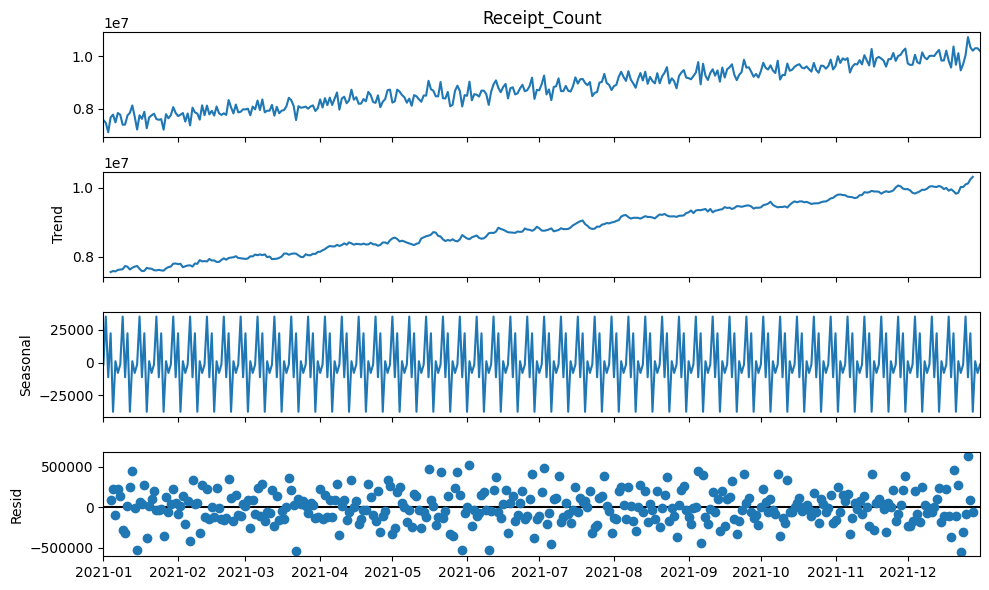

In [170]:
decompose = seasonal_decompose(df['Receipt_Count'],model='additive', period=7)
decompose.plot()
plt.show()

# xgb

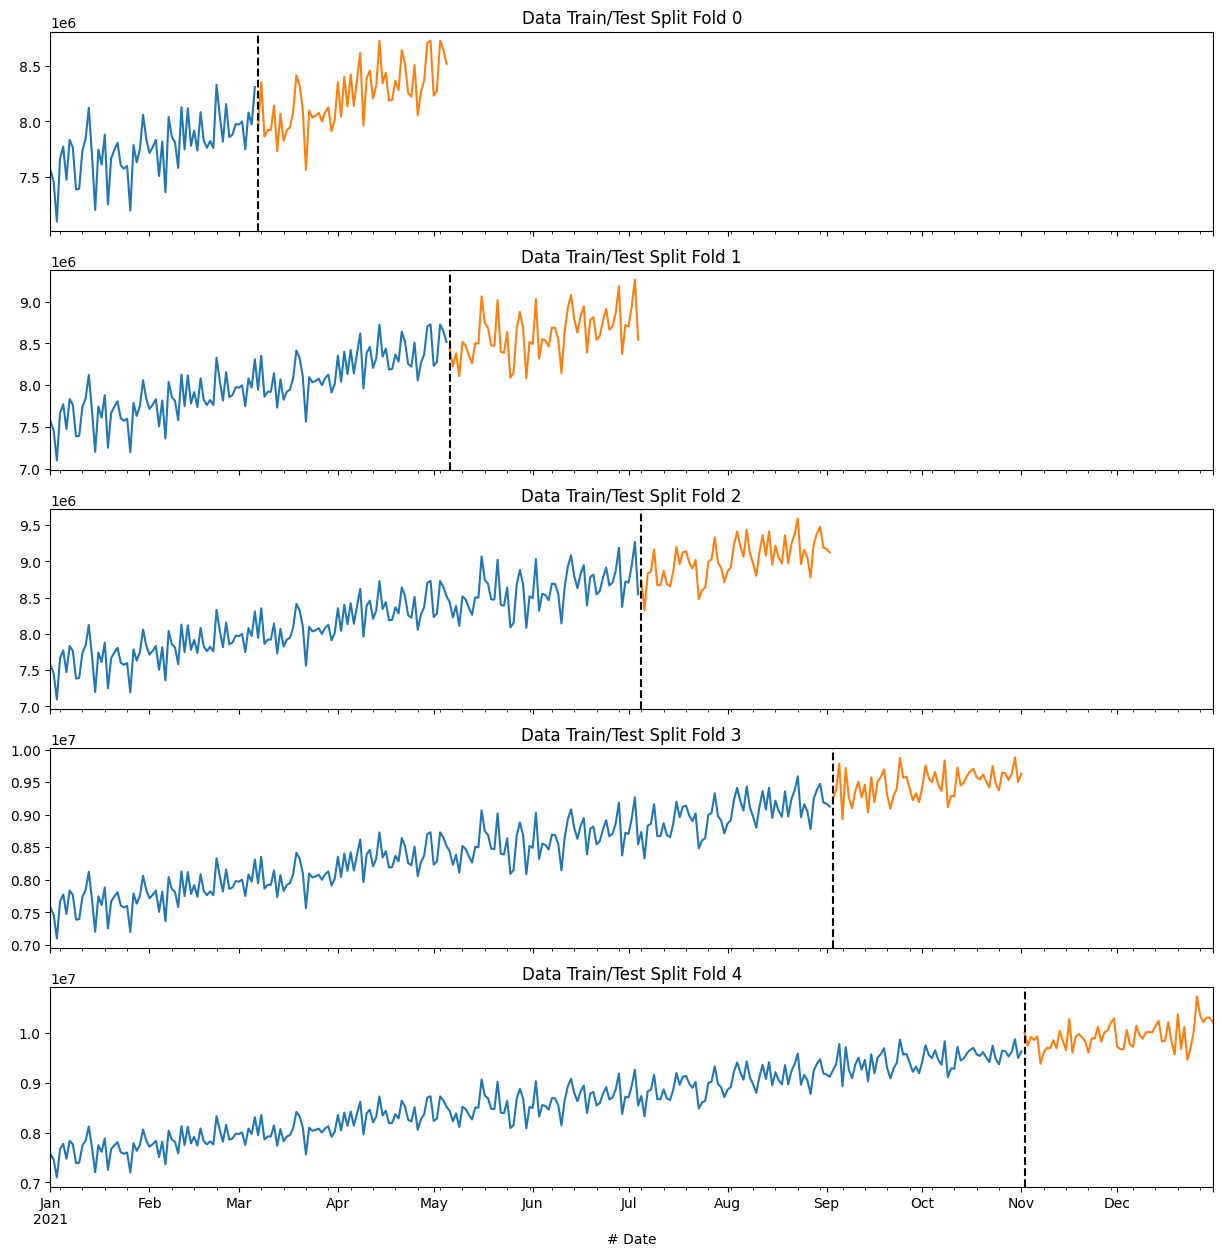

[0]	validation_0-rmse:7694595.67200	validation_1-rmse:8154027.88145
[100]	validation_0-rmse:2869569.41500	validation_1-rmse:3328015.27201
[200]	validation_0-rmse:1092096.63506	validation_1-rmse:1538032.40969
[300]	validation_0-rmse:449781.10945	validation_1-rmse:803289.45106
[400]	validation_0-rmse:233182.02594	validation_1-rmse:508855.41014
[500]	validation_0-rmse:165320.32952	validation_1-rmse:395008.26529
[600]	validation_0-rmse:142921.98697	validation_1-rmse:337121.51651
[700]	validation_0-rmse:134882.58839	validation_1-rmse:308900.75927
[800]	validation_0-rmse:126849.96267	validation_1-rmse:299315.26693
[900]	validation_0-rmse:118586.55655	validation_1-rmse:296467.41917
[999]	validation_0-rmse:110916.06265	validation_1-rmse:294291.95410
[0]	validation_0-rmse:7915705.15823	validation_1-rmse:8539380.99187
[100]	validation_0-rmse:2938225.54582	validation_1-rmse:3555222.07646
[200]	validation_0-rmse:1112654.52125	validation_1-rmse:1560240.46857
[300]	validation_0-rmse:451991.62067	val

In [171]:
# validation set
tss = TimeSeriesSplit(n_splits=5, test_size=None, gap=0)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Receipt_Count'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Receipt_Count'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# adding lag features to the data set
df = add_lags(df)


tss = TimeSeriesSplit(n_splits=5, test_size=None, gap=0)
df = df.sort_index()
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = createFeatures(train)
    test = createFeatures(test)

    FEATURES = ['dayofweek', 'quarter', 'month','year','dayofmonth','dayofyear','weekoftheyear',
                'lag1','lag2','lag3','lag4']
    TARGET = 'Receipt_Count'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

# Retrain on all data
df = createFeatures(df)

FEATURES = ['dayofweek', 'quarter', 'month','year','dayofmonth','dayofyear','weekoftheyear',
                'lag1','lag2','lag3','lag4']
TARGET = 'Receipt_Count'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=900,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

# Create future dataframe
future = pd.date_range('2021-12-31','2022-01-01', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = createFeatures(df_and_future)
df_and_future = add_lags(df_and_future)


future_w_features = df_and_future.query('isFuture').copy()
future_w_features.tail()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


In [172]:
#Saving the original feature set to use it with the tarined model and keep adding the predictions.
df.to_csv('../data/df_xgb.csv')

In [173]:
#Saving the Model

with open('../models/xgb.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(reg, fout)
    

# FB Prophet

In [174]:
df = pd.read_csv('../data/data_daily.csv',index_col='# Date')
df=df.rename(columns={'# Date': 'Date'})
dataframe = df

00:04:20 - cmdstanpy - INFO - Chain [1] start processing
00:04:20 - cmdstanpy - INFO - Chain [1] done processing
00:04:20 - cmdstanpy - INFO - Chain [1] start processing
00:04:20 - cmdstanpy - INFO - Chain [1] done processing


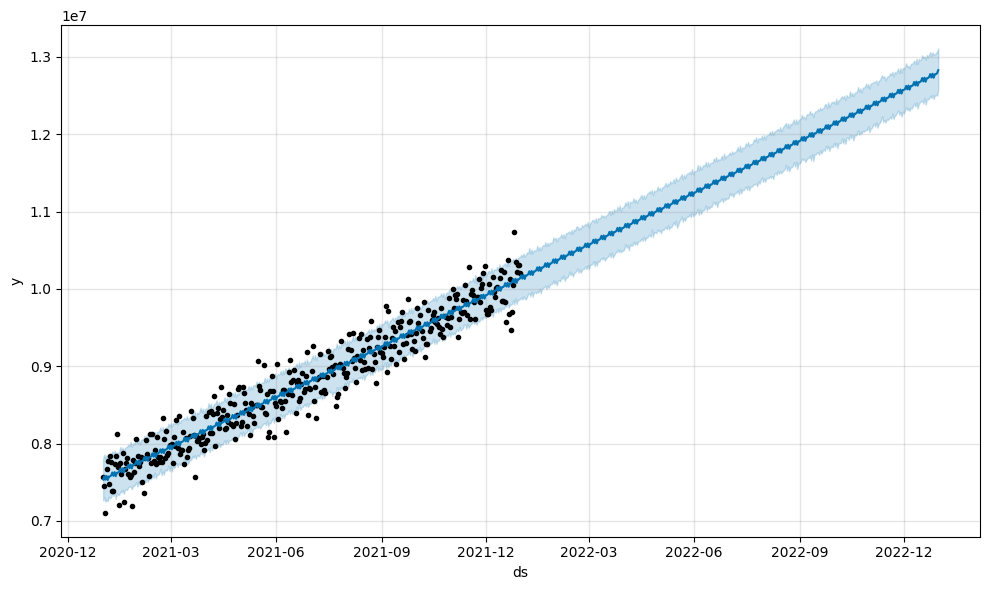

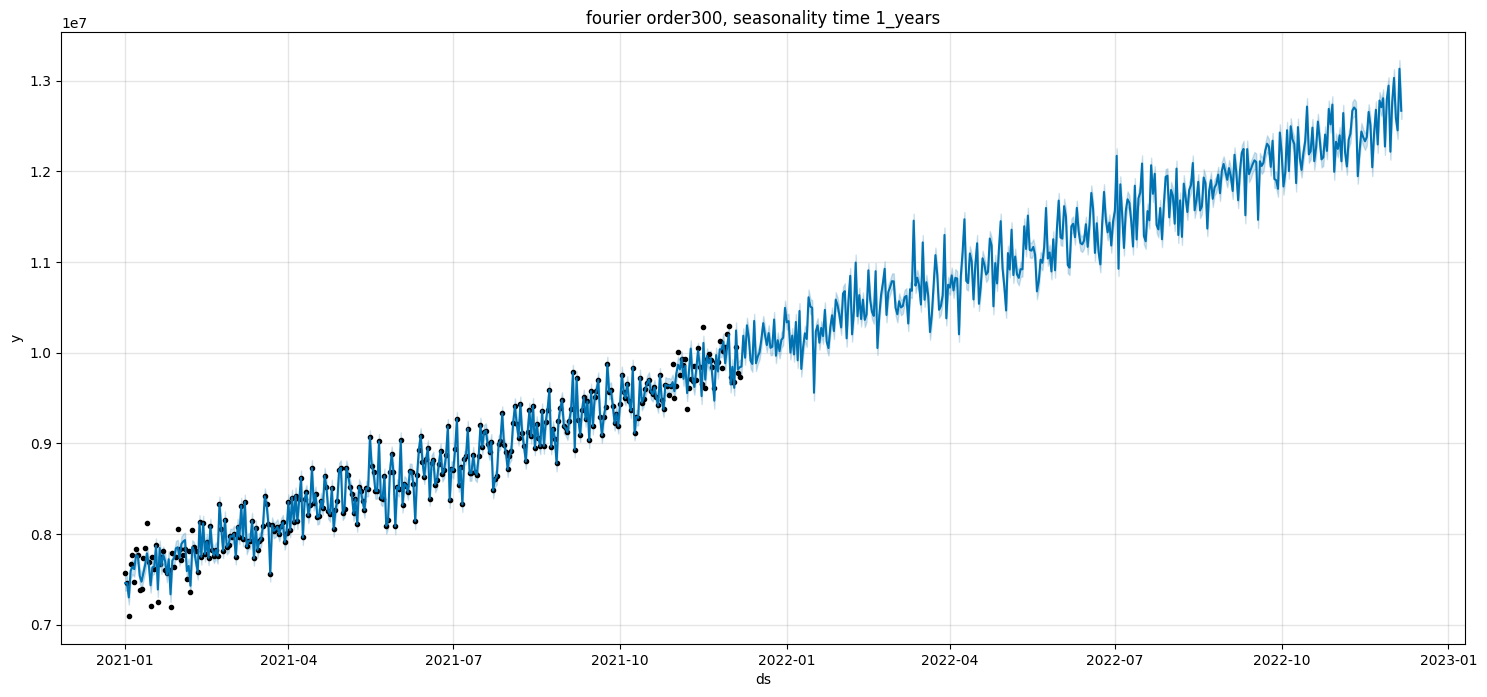

Total Execution Time 0.7568249702453613 seconds


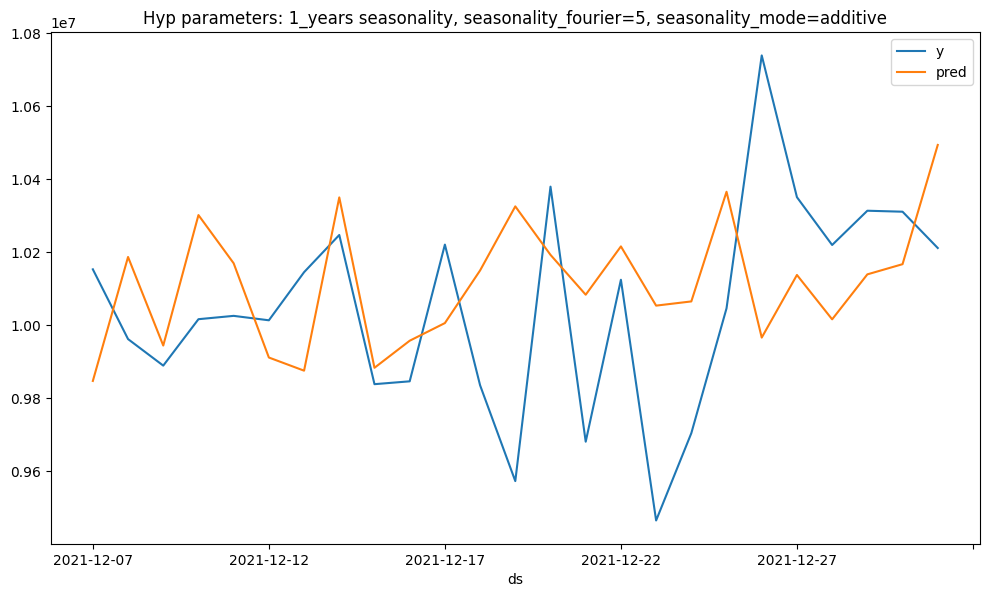

In [175]:
prophet_model = Prophet()
dataframe.head()

dataframe.rename_axis('ds', inplace=True)
dataframe.rename(columns={'Receipt_Count':'y'}, inplace=True)
dataframe.reset_index(inplace=True)
dataframe.head()



prophet_model.fit(dataframe)
future_dataset= prophet_model.make_future_dataframe(periods=365, freq='d') 
future_dataset.tail()

pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

prophet_model.plot(pred);


def fb_prophet_function(data, future_days, seasonality_name, seasonality_val,seasonality_fourier, **params):
   
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_days, freq='d')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();
    

training_set = dataframe[:340] 
validation_set = dataframe[340:]

prophet_model = fb_prophet_function(data=training_set, future_days=365, seasonality_name='1_years', seasonality_val=300, seasonality_fourier=300,seasonality_mode='additive')

training_set.tail()

plot_valid(validation_set, 25, prophet_model)
plt.title("Hyp parameters: 1_years seasonality, seasonality_fourier=5, seasonality_mode=additive");


In [176]:
with open('../models/fbprophet.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(prophet_model, fout)